Data Link:
    https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [0]:
base_url = ''

key_1 = pd.read_csv(base_url+'key_1.csv')
train_1 = pd.read_csv(base_url+'train_1.csv')
sample_submission_1 = pd.read_csv(base_url+'sample_submission_1.csv')

In [3]:
print(train_1.shape, key_1.shape, sample_submission_1.shape)

(24737, 551) (534452, 2) (3005918, 2)


### Understanding the DATA
train_1.csv

Contains 145.063 rows representing different Wikipedia URL pages
Contains 551 columns, first column is the URL page and then each column represents a value in time from 2015-07-01 to 2016-12-31 (1.5 year, total of 550 days), where the value is the number of visits to the page in that day
Jul/2015 - 31 days
Aug/2015 - 31 days
Sep/2015 - 30 days
Oct/2015 - 31 days
Nov/2015 - 30 days
Dec/2015 - 31 days

Total: 184 days

2016 - 366 days (leap year)

Total: 184 + 366 = 550 days

In [4]:
train_1.head()

Page  ...  2016-12-31
0            2NE1_zh.wikipedia.org_all-access_spider  ...        20.0
1             2PM_zh.wikipedia.org_all-access_spider  ...        20.0
2              3C_zh.wikipedia.org_all-access_spider  ...        17.0
3         4minute_zh.wikipedia.org_all-access_spider  ...        11.0
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  ...        10.0

[5 rows x 551 columns]

key_1.csv

Contains 8.703.780 rows, each one representing the "URL page"_"datetime", where datetime varies from 2017-01-01 to 2017-03-01 (total of 60 days), which is the result of the total number of pages multiplied by 60 days (145063 x 60 = 8.703.780)
Contains 2 columns, first one is the "URL page"_"datetime", second one is the ID for that page

In [5]:
key_1.head()

Page            Id
0  !vote_en.wikipedia.org_all-access_all-agents_2...  bf4edcf969af
1  !vote_en.wikipedia.org_all-access_all-agents_2...  929ed2bf52b9
2  !vote_en.wikipedia.org_all-access_all-agents_2...  ff29d0f51d5c
3  !vote_en.wikipedia.org_all-access_all-agents_2...  e98873359be6
4  !vote_en.wikipedia.org_all-access_all-agents_2...  fa012434263a

In [6]:
print(key_1.Page[0])
print
print(key_1.Page[59])
print
print(key_1.Page[60])

!vote_en.wikipedia.org_all-access_all-agents_2017-01-01
!vote_en.wikipedia.org_all-access_all-agents_2017-03-01
!vote_en.wikipedia.org_all-access_spider_2017-01-01


sample_submission_1.csv

Contains 8.703.780 rows, each one having the ID for the page and respective number of visits to the page at that datetime

In [7]:
sample_submission_1.head()

Id  Visits
0  bf4edcf969af     0.0
1  929ed2bf52b9     0.0
2  ff29d0f51d5c     0.0
3  e98873359be6     0.0
4  fa012434263a     0.0

In summary:

We need to predict the number of visits for the period between 2017-01-01 to 2017-03-1 (60 days) from training data (train_1) containing the visits to the 145063 pages in previous period given between 2015-07-01 to 2016-12-31 (550 days).

### Exploratory Data Analisys (EDA)

In [8]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24737 entries, 0 to 24736
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 104.0+ MB


In [9]:
train_1.head()

Page  ...  2016-12-31
0            2NE1_zh.wikipedia.org_all-access_spider  ...        20.0
1             2PM_zh.wikipedia.org_all-access_spider  ...        20.0
2              3C_zh.wikipedia.org_all-access_spider  ...        17.0
3         4minute_zh.wikipedia.org_all-access_spider  ...        11.0
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  ...        10.0

[5 rows x 551 columns]

In [0]:
# Creating a list of wikipedia main sites 
sites = ["wikipedia.org", "commons.wikimedia.org", "www.mediawiki.org"]

In [0]:
# Function to create a new column having the site part of the article page
def filter_by_site(page):
    for site in sites:
        if site in page:
            return site

In [0]:
# Creating a new column having the site part of the article page
train_1['Site'] = train_1.Page.apply(filter_by_site)

In [0]:
# Creating a new column having the site part of the article page
train_1['Site'] = train_1.Page.apply(filter_by_site)

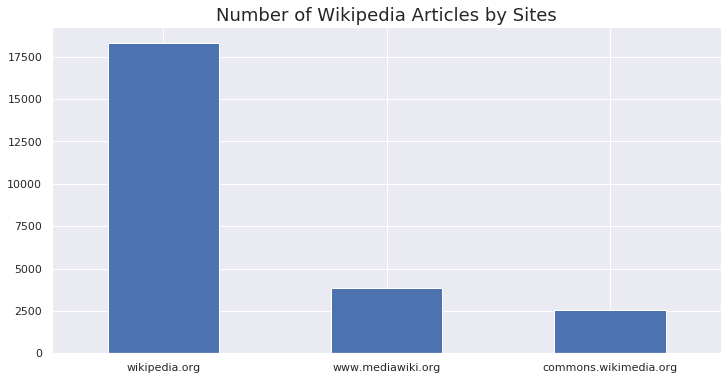

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.figure(figsize=(12, 6))
plt.title("Number of Wikipedia Articles by Sites", fontsize="18")
train_1['Site'].value_counts().plot.bar(rot=0);

In [15]:
# Checking which country codes exist in the article pages
train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,0].str[-3:].value_counts().index.to_list()

['_fr', '_en', '_zh', 'nts', '_ru', 'der']

In [16]:
# Creating a list of country codes
train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,0].str[-2:].value_counts().index.to_list()[0:7]

['fr', 'en', 'zh', 'ts', 'ru', 'er']

In [17]:
# Checking which agents + access exist in the article pages and creating a list with them
train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,1].str[1:].value_counts().index.to_list()

['desktop_all-agents',
 'all-access_spider',
 'mobile-web_all-agents',
 'all-access_all-agents']

In [0]:
# Creating the list of country codes and agents
countries = train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,0].str[-2:].value_counts().index.to_list()[0:7]
agents = train_1.Page.str.split(pat=".wikipedia.org", expand=True).iloc[:,1].str[1:].value_counts().index.to_list()

In [0]:
# Function to create a new column having the country code part of the article page
def filter_by_country(page):
    for country in countries:
        if "_"+country+"." in page:
            return country

In [0]:
# Creating a new column having the country code part of the article page
train_1['Country'] = train_1.Page.apply(filter_by_country)

In [0]:
# Function to create a new column having the agent + access part of the article page
def filter_by_agent(page):
    for agent in agents:
        if agent in page:
            return agent

In [0]:
# Creating a new column having the agent part of the article page
train_1['Agent'] = train_1.Page.apply(filter_by_agent)

In [23]:
# Understanding what are the NaN values for the Country column
# It seems that the URL page does not contain the country code for those cases

train_1.Page[train_1['Country'].isna() == True]

13332      Accueil_commons.wikimedia.org_all-access_spider
13333    Atlas_of_Asia_commons.wikimedia.org_all-access...
13334    Atlas_of_Europe_commons.wikimedia.org_all-acce...
13335    Atlas_of_World_War_II_commons.wikimedia.org_al...
13336    Atlas_of_colonialism_commons.wikimedia.org_all...
                               ...                        
23461    VisualEditor/Portal_www.mediawiki.org_mobile-w...
23462    Wikibase/DataModel_www.mediawiki.org_mobile-we...
23463    Wikimedia_Apps/iOS_FAQ/es_www.mediawiki.org_mo...
23464    Wikimedia_Engineering/id_www.mediawiki.org_mob...
23465    Wikimedia_Hackathon_2017/Register_and_Attend_w...
Name: Page, Length: 6403, dtype: object

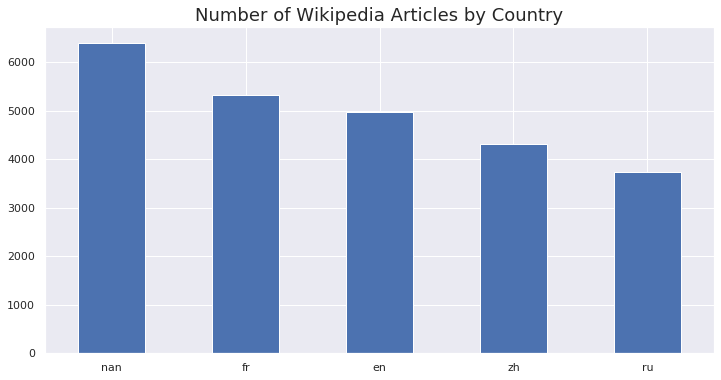

In [24]:
plt.figure(figsize=(12, 6))
plt.title("Number of Wikipedia Articles by Country", fontsize="18")
train_1['Country'].value_counts(dropna=False).plot.bar(rot=0);

In [25]:
train_1['Agent'].value_counts(dropna=False)

desktop_all-agents       9022
all-access_spider        6860
mobile-web_all-agents    5832
all-access_all-agents    3023
Name: Agent, dtype: int64

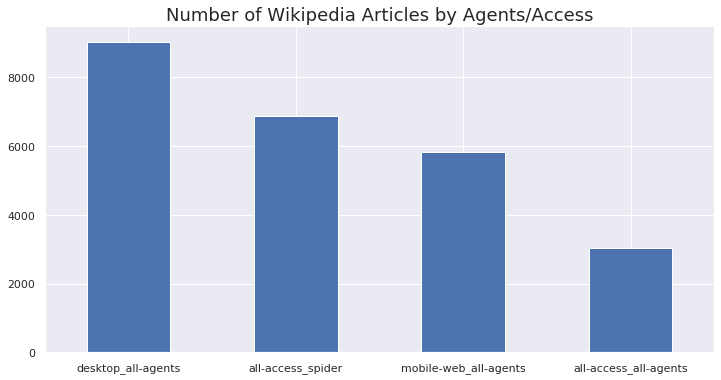

In [26]:
plt.figure(figsize=(12, 6))
plt.title("Number of Wikipedia Articles by Agents/Access", fontsize="18")
train_1['Agent'].value_counts().plot.bar(rot=0);

In [27]:
# Creating a sample dataset from the Train dataset for analysis
train_1_sample = train_1.drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)
train_1_sample

Page  ...  2016-12-31
16062  Алфёрова,_Ирина_Ивановна_ru.wikipedia.org_mobi...  ...       744.0
10572  The_Neon_Demon_en.wikipedia.org_desktop_all-ag...  ...      2179.0
19093    Интернет_ru.wikipedia.org_mobile-web_all-agents  ...       736.0
14206  File:Le_Squelette_01.jpg_commons.wikimedia.org...  ...         0.0
15550  File:Sphinx_Observatory.jpg_commons.wikimedia....  ...         2.0
10443   Steven_Avery_en.wikipedia.org_desktop_all-agents  ...       827.0

[6 rows x 551 columns]

In [28]:
# Transposing the sample dataset to have Date Time at the index
train_1_sampleT = train_1_sample.drop('Page', axis=1).T
train_1_sampleT.columns = train_1_sample.Page.values
train_1_sampleT.shape

(550, 6)

In [29]:
train_1_sampleT.head()

Алфёрова,_Ирина_Ивановна_ru.wikipedia.org_mobile-web_all-agents  ...  Steven_Avery_en.wikipedia.org_desktop_all-agents
2015-07-01                                              341.0                ...                                              37.0
2015-07-02                                              335.0                ...                                              32.0
2015-07-03                                              289.0                ...                                              25.0
2015-07-04                                              263.0                ...                                              24.0
2015-07-05                                              300.0                ...                                              25.0

[5 rows x 6 columns]

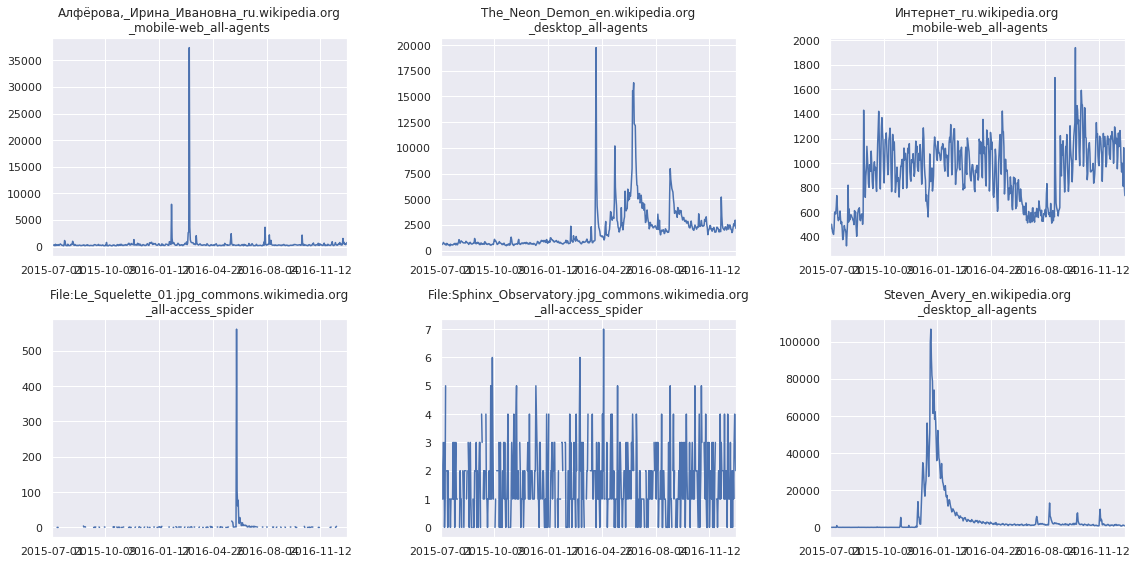

In [30]:
# Plotting the Series from the sample dataset 
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT[v].plot()

plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


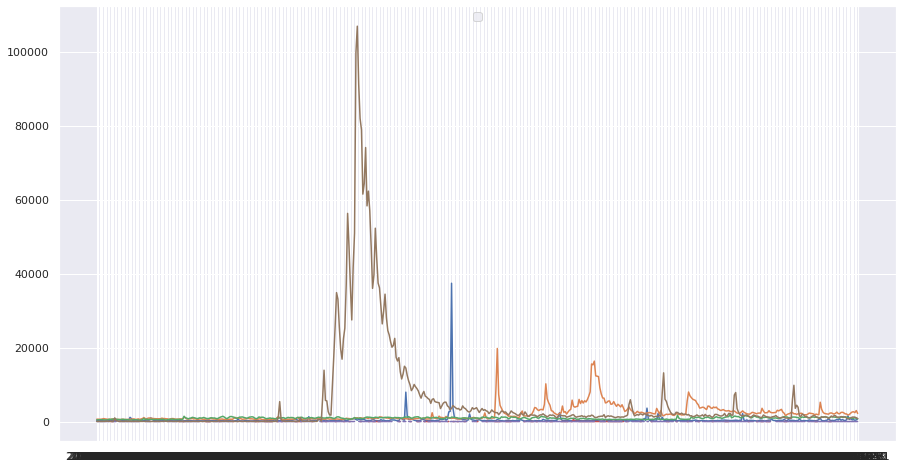

In [31]:
# Plotting the Series from the sample dataset at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT.columns:
    plt.plot(train_1_sampleT[v])
    plt.legend(loc='upper center');

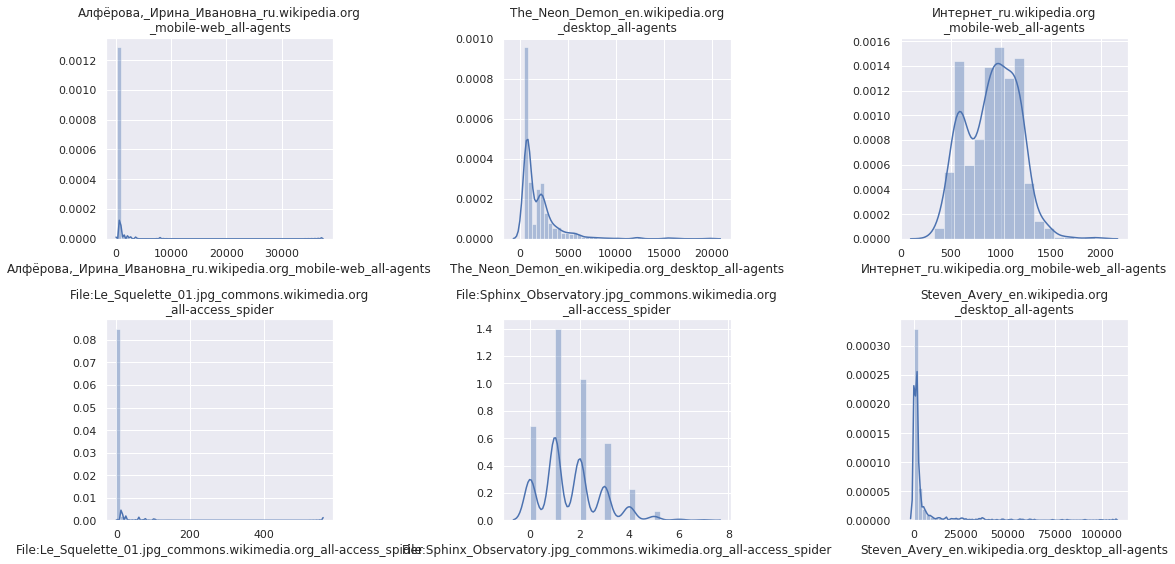

In [32]:
# Plotting the histograms for the Series from the sample dataset
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    sns.distplot(train_1_sampleT[v])

plt.tight_layout();

In [33]:
# Checking that the number of visits to the Wikipedia Articles have Gaussian Distribution (p-value=0)
from scipy.stats import kstest, ks_2samp

pages = list(train_1_sampleT.columns)

print("Kolgomorov-Smirnov - Normality Test")
print()

for p in pages:
    print(p,':', kstest(train_1_sampleT[p], 'norm', alternative = 'less'))    

Kolgomorov-Smirnov - Normality Test

Алфёрова,_Ирина_Ивановна_ru.wikipedia.org_mobile-web_all-agents : KstestResult(statistic=1.0, pvalue=0.0)
The_Neon_Demon_en.wikipedia.org_desktop_all-agents : KstestResult(statistic=1.0, pvalue=0.0)
Интернет_ru.wikipedia.org_mobile-web_all-agents : KstestResult(statistic=1.0, pvalue=0.0)
File:Le_Squelette_01.jpg_commons.wikimedia.org_all-access_spider : KstestResult(statistic=nan, pvalue=nan)
File:Sphinx_Observatory.jpg_commons.wikimedia.org_all-access_spider : KstestResult(statistic=nan, pvalue=nan)
Steven_Avery_en.wikipedia.org_desktop_all-agents : KstestResult(statistic=1.0, pvalue=0.0)


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


### Exploring Groups of Time Series for Different Sites

In [34]:
# List of the main Wikipedia Article sites
sites

['wikipedia.org', 'commons.wikimedia.org', 'www.mediawiki.org']

In [0]:
# Creating sample datasets from the train dataset and filtering them by sites
train_1_sample_site0 = train_1[train_1['Site'] == sites[0]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)
train_1_sample_site1 = train_1[train_1['Site'] == sites[1]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)
train_1_sample_site2 = train_1[train_1['Site'] == sites[2]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)

# Transposing them to have the Date Time as index
train_1_sampleT_site0 = train_1_sample_site0.drop('Page', axis=1).T
train_1_sampleT_site0.columns = train_1_sample_site0.Page.values
train_1_sampleT_site1 = train_1_sample_site1.drop('Page', axis=1).T
train_1_sampleT_site1.columns = train_1_sample_site1.Page.values
train_1_sampleT_site2 = train_1_sample_site2.drop('Page', axis=1).T
train_1_sampleT_site2.columns = train_1_sample_site2.Page.values

### Time Series of "WIKIPEDIA.ORG" sites only

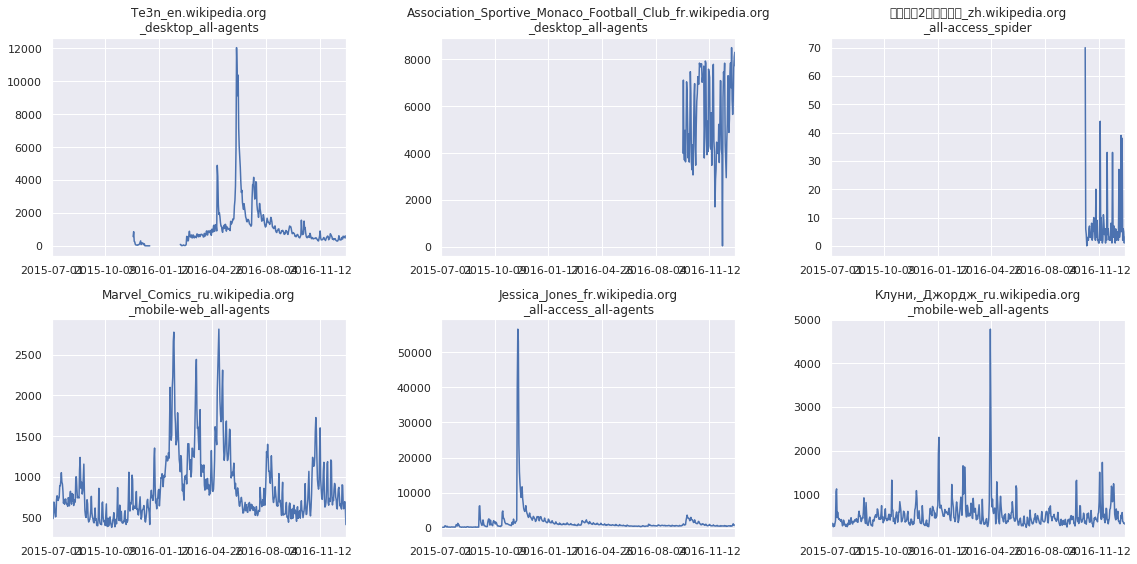

In [36]:
import warnings
warnings.filterwarnings('ignore')

# Plotting the Series from the sample datasets
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_site0.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_site0[v].plot()

plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


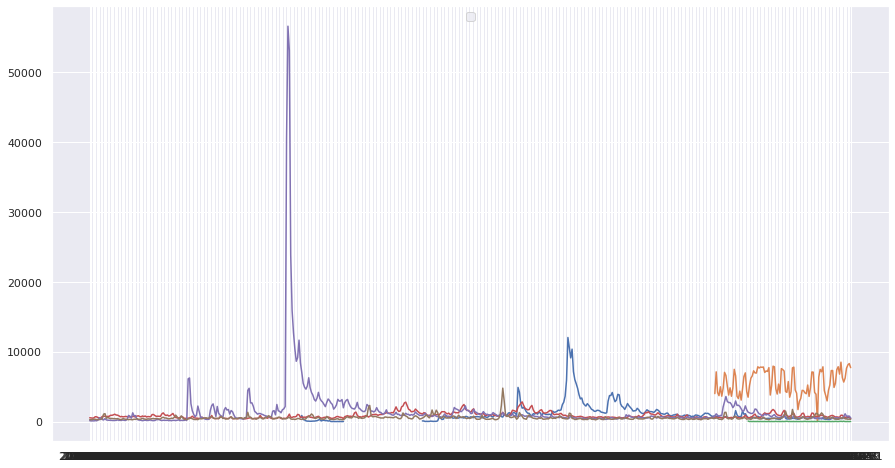

In [37]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_site0.columns:
    plt.plot(train_1_sampleT_site0[v])
    plt.legend(loc='upper center');

### Time Series of "COMMONS.WIKIMEDIA.ORG" sites only

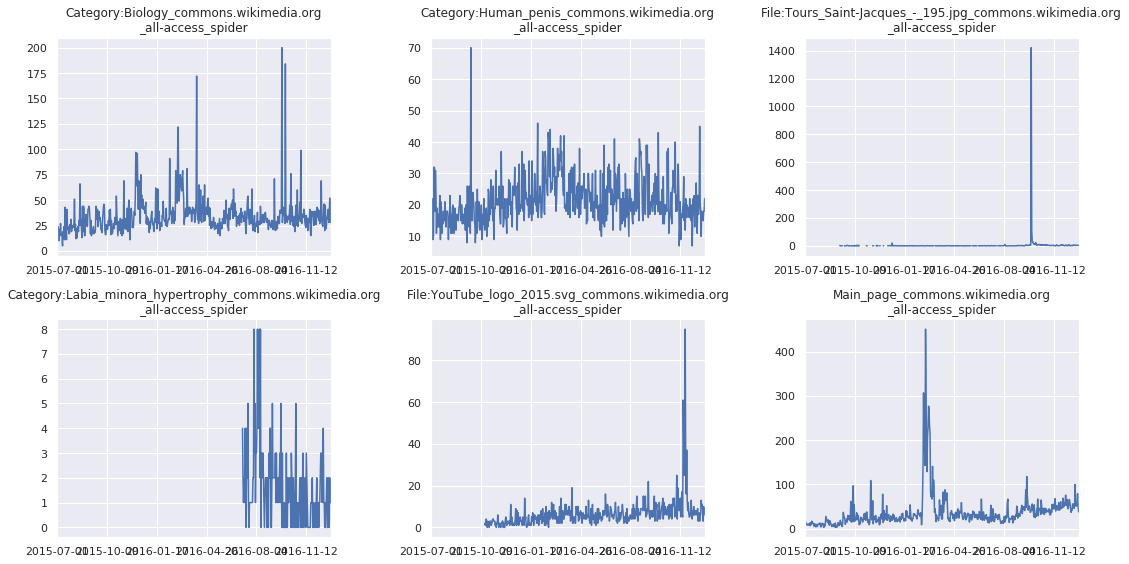

In [38]:
# Plotting the Series from the sample datasets
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_site1.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_site1[v].plot()

plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


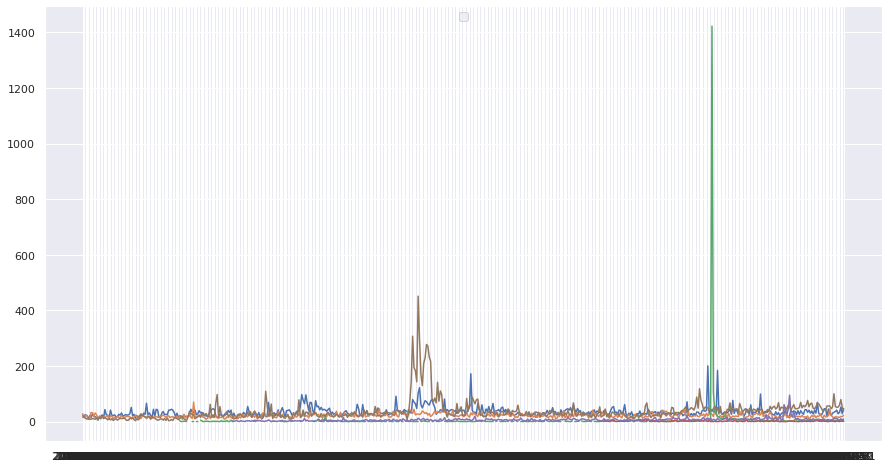

In [39]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_site1.columns:
    plt.plot(train_1_sampleT_site1[v])
    plt.legend(loc='upper center');

### Time Series of "WWW.MEDIAWIKI.ORG" sites only

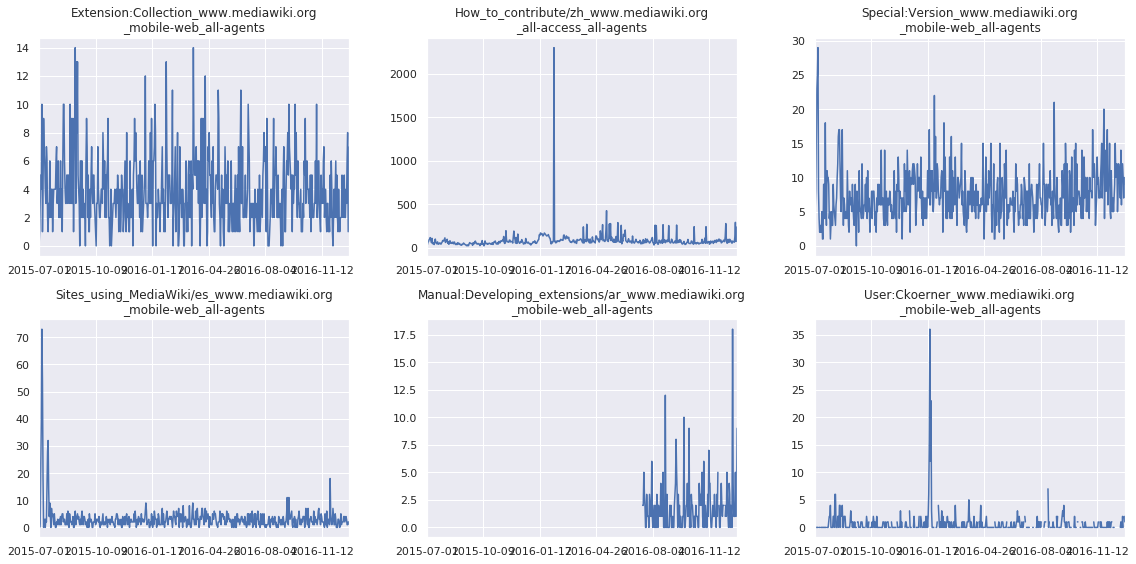

In [40]:
# Plotting the Series from the sample datasets
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_site2.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_site2[v].plot()

plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


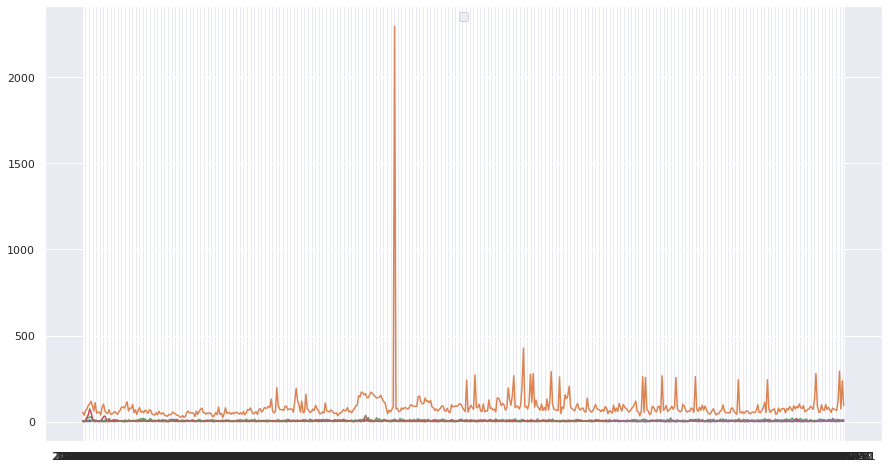

In [41]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_site2.columns:
    plt.plot(train_1_sampleT_site2[v])
    plt.legend(loc='upper center');

In [42]:
train_1_sampleT_site2.columns[4]

'Manual:Developing_extensions/ar_www.mediawiki.org_mobile-web_all-agents'

Notes:

For all the sites samples, some series presented missing data (NaNs).

For one of the WWW.MEDIAWIKI.ORG Series sample, noticed there was no data at all.
For this series, the URL contains the IP address instead of DNS name and it starts with "User:"

### Exploring a Group of Time Series for a Specific Country - DE

In [43]:
# List of the Wikipedia Article country codes
countries

['fr', 'en', 'zh', 'ts', 'ru', 'er']

In [0]:
# Creating a sample dataset from the train dataset for countries having "de" code
train_1_sample_de = train_1[train_1['Country'] == countries[2]].drop(['Site','Country','Agent'], axis=1).sample(6, random_state=42)

# Transposing the sample dataset to have Date Time at the index
train_1_sampleT_de = train_1_sample_de.drop('Page', axis=1).T
train_1_sampleT_de.columns = train_1_sample_de.Page.values

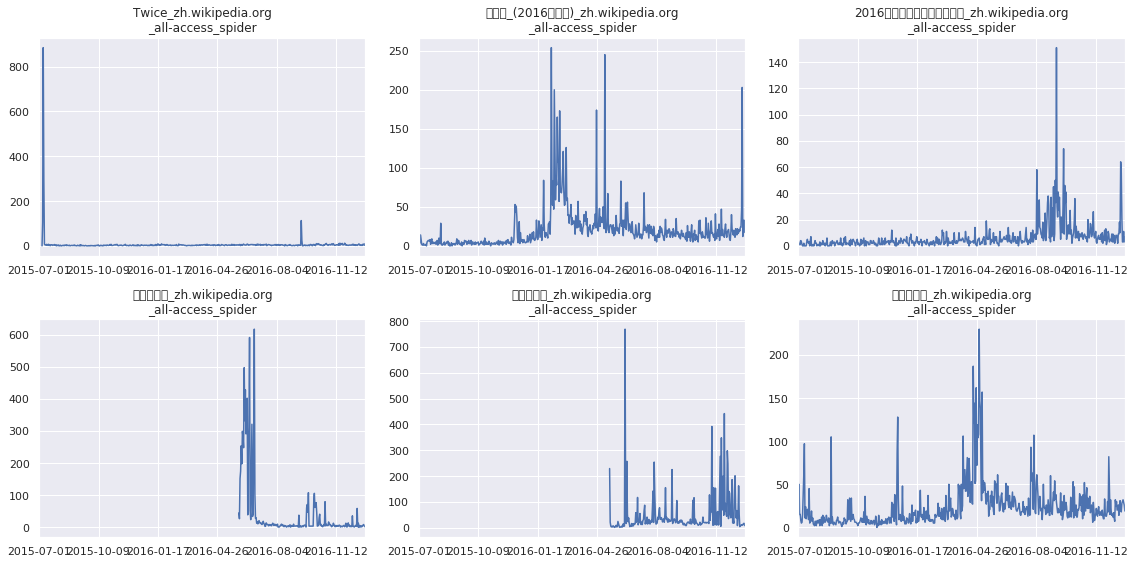

In [45]:
# Plotting the Series from the sample dataset
plt.figure(figsize=(16,8))

for k, v in enumerate(train_1_sampleT_de.columns):
    plt.subplot(2, 3, k + 1)
    plt.title( str(v.split(".org")[0])+".org"+"\n"+str(v.split(".org")[1]) )
    train_1_sampleT_de[v].plot()

plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


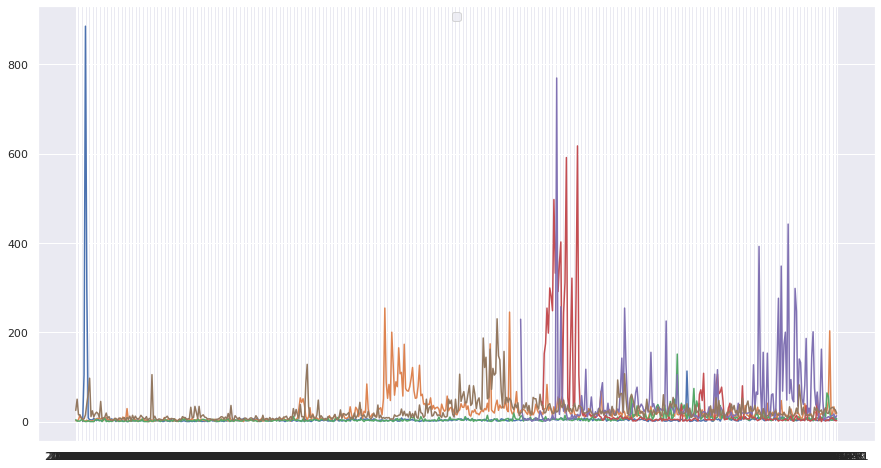

In [46]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sampleT_de.columns:
    plt.plot(train_1_sampleT_de[v])
    plt.legend(loc='upper center');

### Modeling with Facebook Prophet
Facebook Prophet function is used do define a Prophet forecasting model in Python.

I will now use Prophet to model a specific Time Series got from samples of the training dataset.

In [0]:
# !pip install fbprophet

In [0]:
# Import Prophet library
from fbprophet import Prophet

In [48]:
# Picked up one Time Series for the prophet modeling
train_1_sampleT.columns[1]

'The_Neon_Demon_en.wikipedia.org_desktop_all-agents'

In [49]:
# Creating a dataframe for the Time Series from the train_1 samples dataset
ds = pd.Series(train_1_sampleT.index)
y = pd.Series(train_1_sampleT.iloc[:,1].values)
frame = { 'ds': ds, 'y': y }
df = pd.DataFrame(frame)
df.head()

ds      y
0  2015-07-01  632.0
1  2015-07-02  624.0
2  2015-07-03  595.0
3  2015-07-04  612.0
4  2015-07-05  683.0

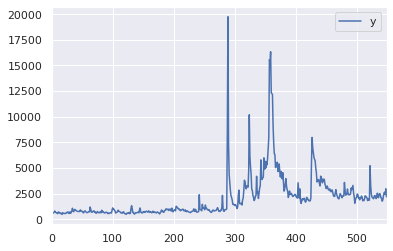

In [50]:
df.plot();

In [51]:
# Instantiate and fit the Prophet model with no hyperparameters at all
m = Prophet()
m.fit(df);

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
# Make dataframe for the future predictions to the next 60 days
# By default it will also include the dates from the history
# In summary it will have 550 + 60 days (610)
future = m.make_future_dataframe(periods=60)
future.tail()

ds
605 2017-02-25
606 2017-02-26
607 2017-02-27
608 2017-02-28
609 2017-03-01

In [53]:
# Predicting the values from the future dataframe
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
605 2017-02-25  1047.941206  -974.171912  3207.940309
606 2017-02-26  1132.133005  -929.331758  3329.605702
607 2017-02-27  1182.071357  -975.120045  3354.309266
608 2017-02-28  1082.359940 -1050.479923  3215.396307
609 2017-03-01  1148.108630  -875.298110  3250.336958

In [54]:
forecast.shape

(610, 16)

In [55]:
# The forecast object here is a new dataframe that includes a column yhat with the forecast, 
# as well as columns for components and uncertainty intervals
forecast.head()

ds       trend  ...  multiplicative_terms_upper        yhat
0 2015-07-01  525.668295  ...                         0.0  528.695919
1 2015-07-02  527.399575  ...                         0.0  559.832482
2 2015-07-03  529.130854  ...                         0.0  756.951909
3 2015-07-04  530.862134  ...                         0.0  382.737105
4 2015-07-05  532.593413  ...                         0.0  481.406491

[5 rows x 16 columns]

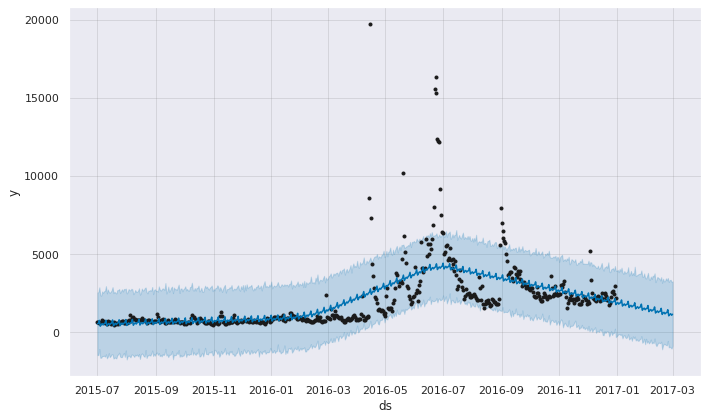

In [56]:
# Plotting the forecast by calling the Prophet.plot method and passing in the forecast dataframe
fig1 = m.plot(forecast)


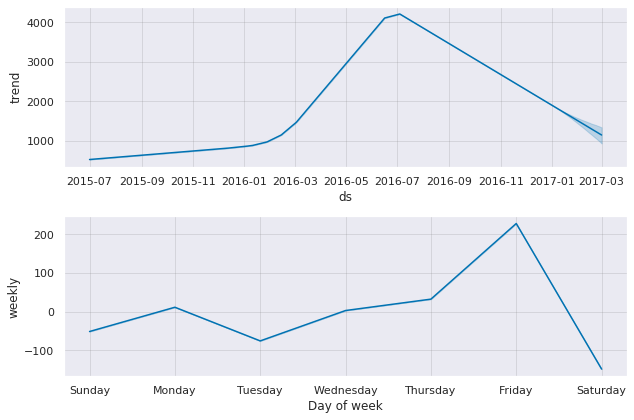

In [57]:
# Plotting the forecast components by calling the Prophet.plot_components method
# By default it includes the trend and seasonality of the time series
fig2 = m.plot_components(forecast)

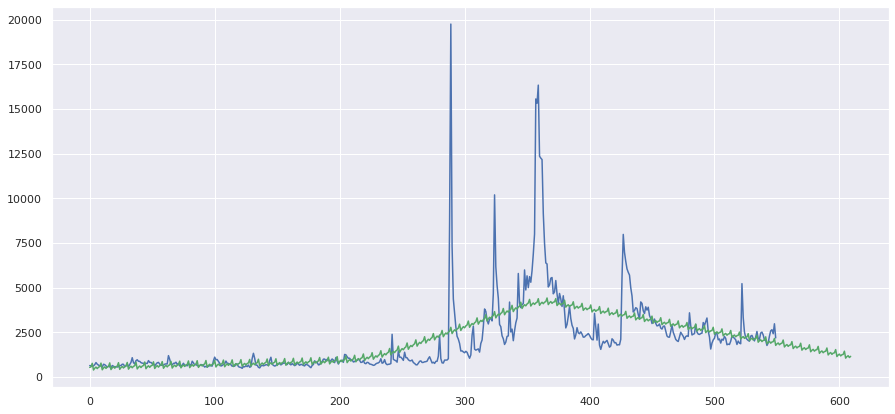

In [58]:
# Plotting both the Actual values and Predict values at the same graph for comparison
plt.figure(figsize=(15, 7))
plt.plot(df.y)                  # Actual values in default blue color
plt.plot(forecast.yhat, "g");   # Predicted values in green color

**Conclusion**: in this case it was possible to capture only the trend

**Prophet - Saturating forecasts**
As per the above results, the time Series prediction shows a trend to the bottom, reaching negative values, which is not accepted in this case. There should be no negative visits to a Wikipedia Article...

For this reason, I tried to use the prophet logistic growth model handling a Saturating Minimum, setting the floor value to zero. However, in order to use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.

In [59]:
forecast['yhat'].tail()

605    1047.941206
606    1132.133005
607    1182.071357
608    1082.359940
609    1148.108630
Name: yhat, dtype: float64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


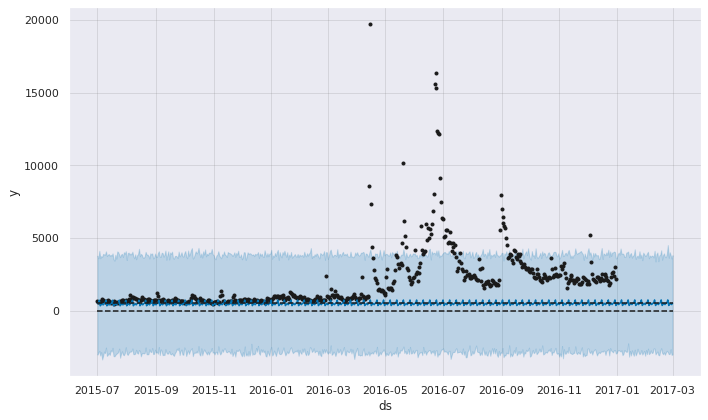

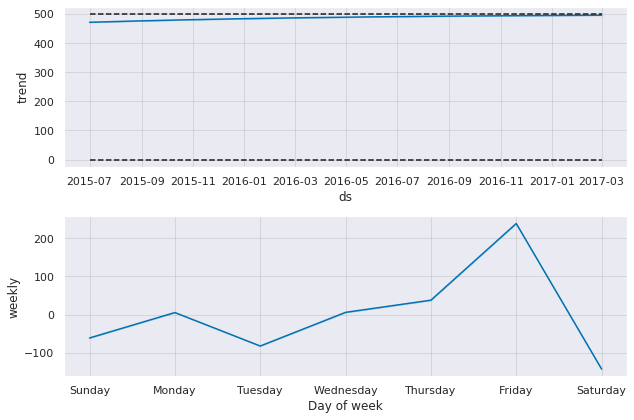

In [60]:
# Setting the floor value to 0 and the capacity to a lower value in the future
df['cap'] = 500
df['floor'] = 0.0
future['cap'] = 500
future['floor'] = 0.0

# Instantiating prophet 'logistic' growth mode, then fitting and predicting future values
m = Prophet(growth='logistic')
forecast = m.fit(df).predict(future)

# Plotting both the forecast predictions and components
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

**Conclusion**: in this case the prediction trend reached the capacity value defined (500). I will need to explore other prophet parameters to get better results.

**Prophet - Seasonality**
I will include the default seasonality parameters to the Prophet model now.

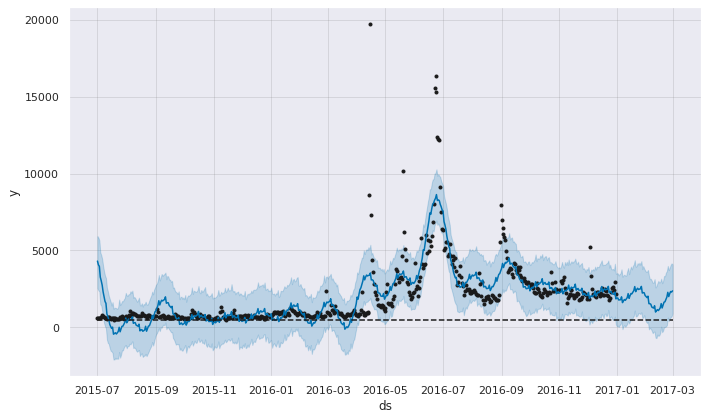

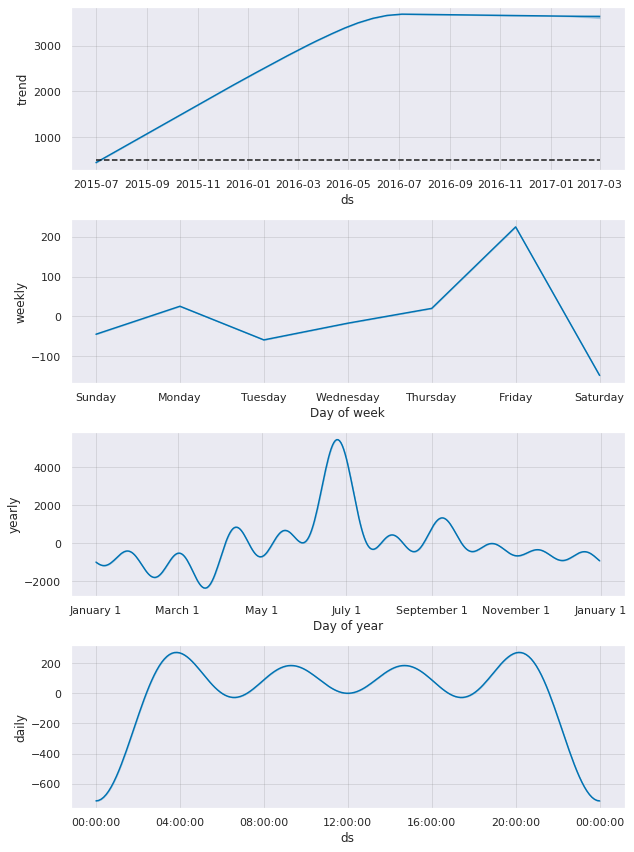

In [61]:
# Instantiate prophet with default seasonality parameters, fitting and predicting the future
# Plotting both the forecast and its components
# I will keep the default growth='linear' by now instead of 'logistic'
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
forecast = m.fit(df).predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

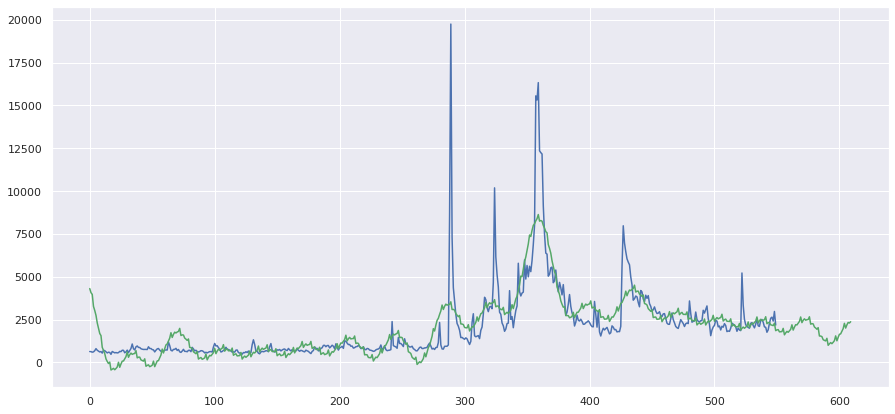

In [62]:
# Plotting both the Actual values and Predict values at the same graph for comparison
plt.figure(figsize=(15, 7))
plt.plot(df.y)                  # Actual values in default blue color
plt.plot(forecast.yhat, "g");   # Predicted values in green color


**Conclusion**: In this case, the fit was much better, which was expected since the seasonality capture the most relevant frequencies. Seasonalities are estimated using a partial Fourier sum. However, we could not capture the high picks.

**Prophet - Changepoints**
Now I will explore the use of Prophet changepoints to automatically detect these abrupt changes in the time series trajectories and see if it will allow the trend to adapt appropriately.
```
## This is formatted as code
```



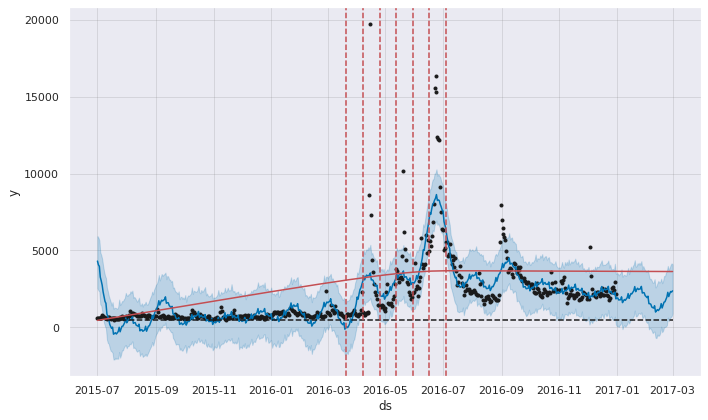

In [63]:
# Checking the locations of the significant changepoints
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series.

Since I still see some changepoints after 80%, I will increase it to check for other ones.

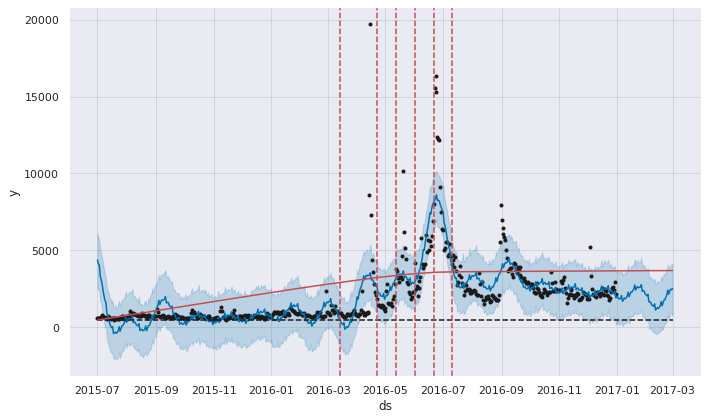

In [64]:
# Increasing the 'changepoint_range' parameter from default 80% to 90%
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
            changepoint_range=0.9)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

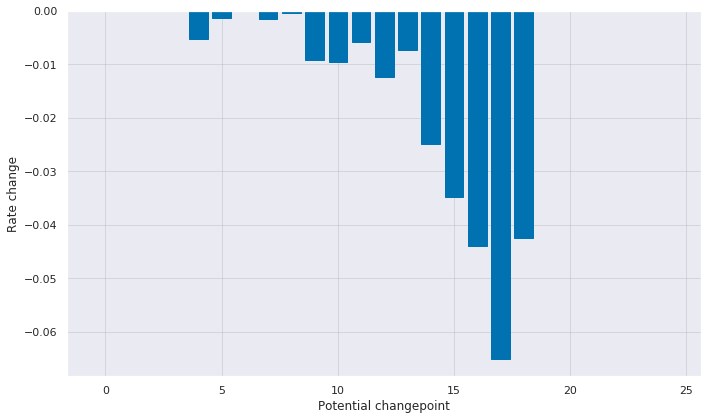

In [65]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

Conclusion: The trend is going down faster when increasing the changepoint_range, making the prediction values more negative, which doesn't make sense. So I will keep changepoint_range to default 80%.

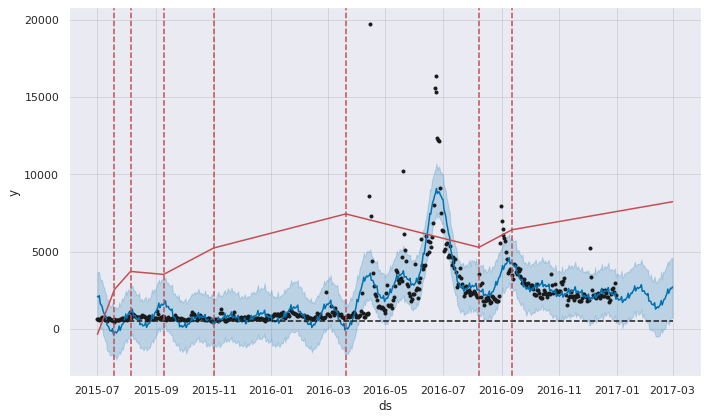

In [66]:
# Changing the changepoint_range back to 80% since I don't want to make the trend more negative
# Also increasing the changepoint_prior_scale from default 0.05 to 0.7
# By default, changepoint_prior_scale parameter is set to 0.05, andi ncreasing it will make the trend more flexible
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
            changepoint_range=0.8, changepoint_prior_scale=0.7)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

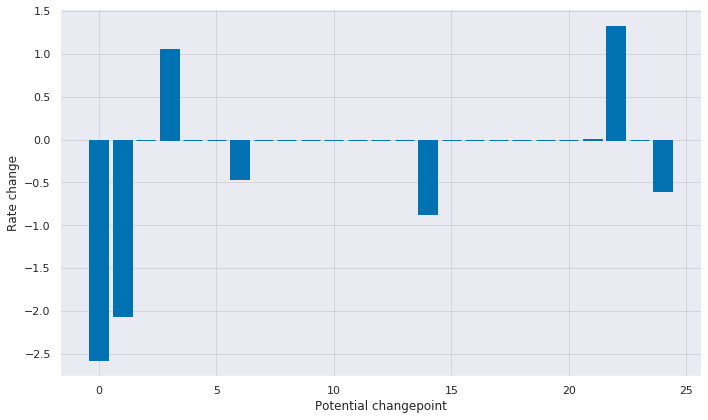

In [67]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

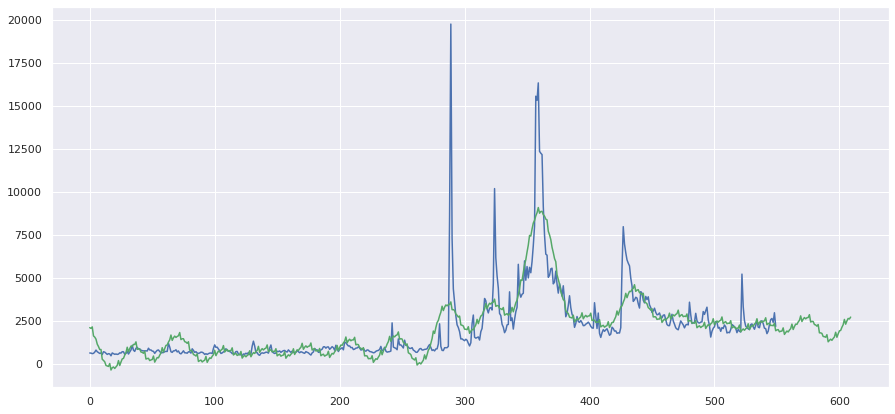

In [68]:
# Plotting both the Actual values and Predict values at the same graph for comparison
plt.figure(figsize=(15, 7))
plt.plot(df.y)                  # Actual values in default blue color
plt.plot(forecast.yhat, "g");   # Predicted values in green color

**Conclusion**: Now we got a pretty good model at this point.

**Prophet** - **Holidays**
Now I will include a dataframe for holidays. Since the wikipedia article time series I am analyzing has the country code "es", I will use the Spain holiday. I will also add years from 2015 to 2017 to the dataframe.

In [69]:
train_1_sampleT.columns[1]

'The_Neon_Demon_en.wikipedia.org_desktop_all-agents'

In [70]:
"_es." in train_1_sampleT.columns[1]

False

In [0]:
from datetime import date
import holidays

# Select country
es_holidays = holidays.Spain(years = [2015,2016,2017])
es_holidays = pd.DataFrame.from_dict(es_holidays, orient='index')
es_holidays = pd.DataFrame({'holiday': 'Spain', 'ds': es_holidays.index})

In [72]:
es_holidays.head()

holiday          ds
0   Spain  2016-01-01
1   Spain  2016-01-06
2   Spain  2016-03-25
3   Spain  2016-05-01
4   Spain  2016-08-15

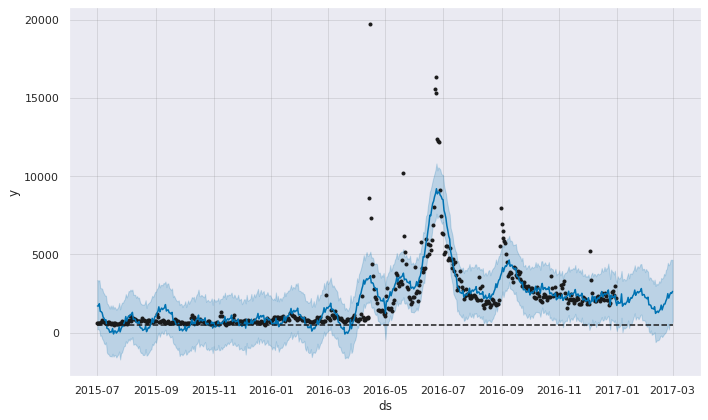

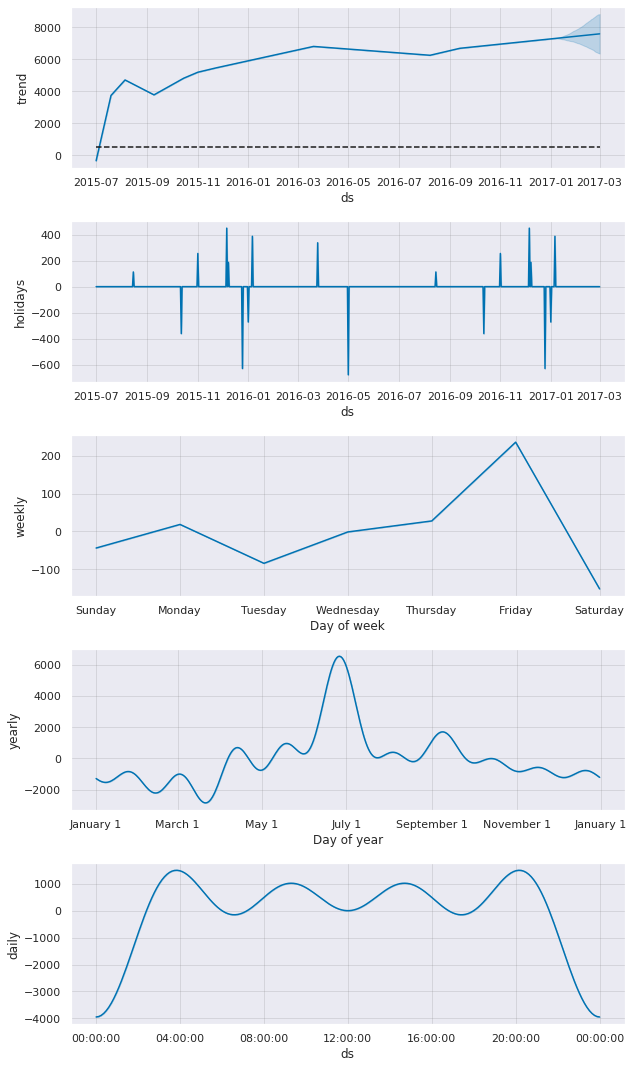

In [73]:
# Instantiate prophet with seasonality, changepoints and holidays parameters
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
            changepoint_range=0.8, changepoint_prior_scale=0.7,
            holidays=es_holidays)
m.add_country_holidays(country_name='ES')
# Fitting and predicting the future
forecast = m.fit(df).predict(future)
# Plotting both the forecast and its components
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

**Prophet - Uncertainty interval¶**
**Uncertainty in the trend** 
The width of the uncertainty intervals (by default 80%) can be set using the parameter interval_width.
I will increase it to 95%.

**Uncertainty in seasonality**
This parameter determines if the model uses Maximum a posteriori (MAP) estimation or a full Bayesian inference with the specified number of Markov Chain Monte Carlo (MCMC) samples to train and predict. So if you make MCMC zero then it will do MAP estimation, otherwise you need to specify the number of samples to use with MCMC.

**Source: Implementing Facebook Prophet efficiently**

Since we are using the SMAPE as the evaluation metric, I decided to keep mcmc_samples parameters to the default zero value.

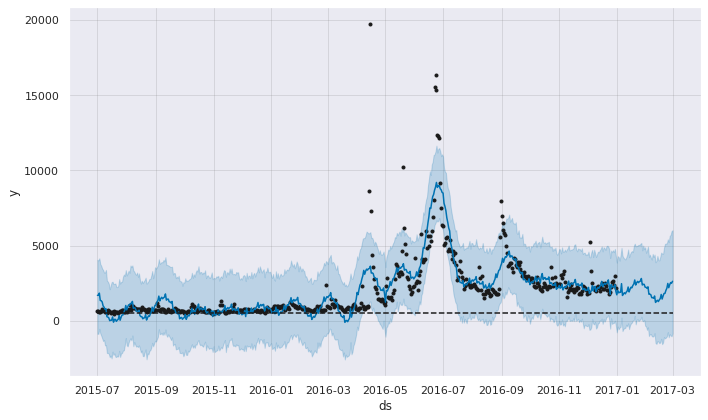

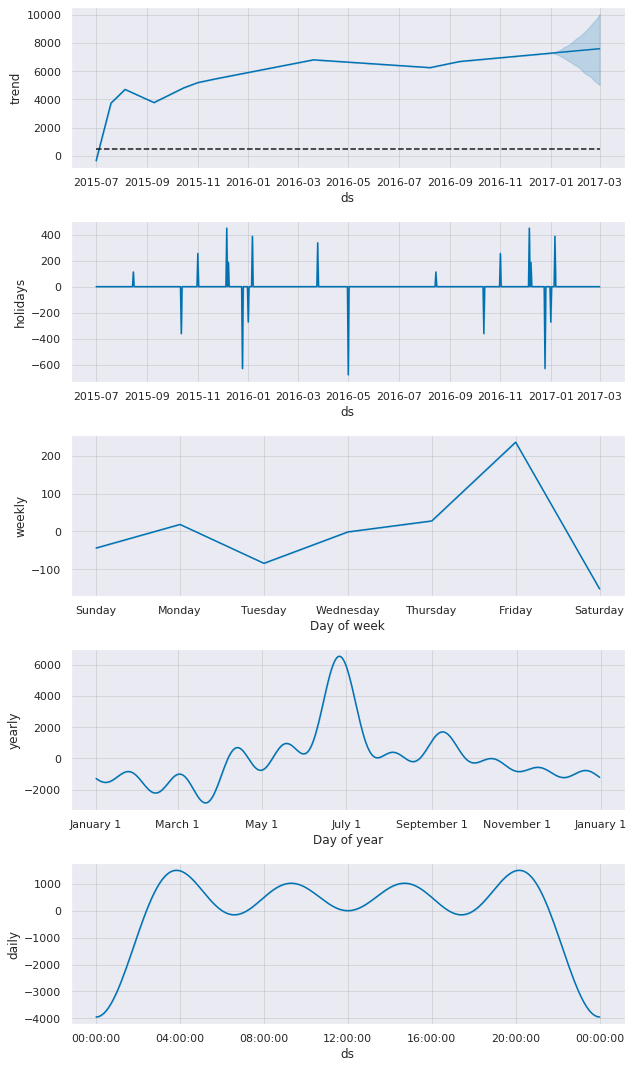

In [74]:
# Instantiate prophet with seasonality, changepoints and holidays parameters
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
            changepoint_range=0.8, changepoint_prior_scale=0.7,
            holidays=es_holidays,
            interval_width=0.95,
            mcmc_samples=0)
m.add_country_holidays(country_name='ES')
# Fitting and predicting the future
forecast = m.fit(df).predict(future)
# Plotting both the forecast and its components
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

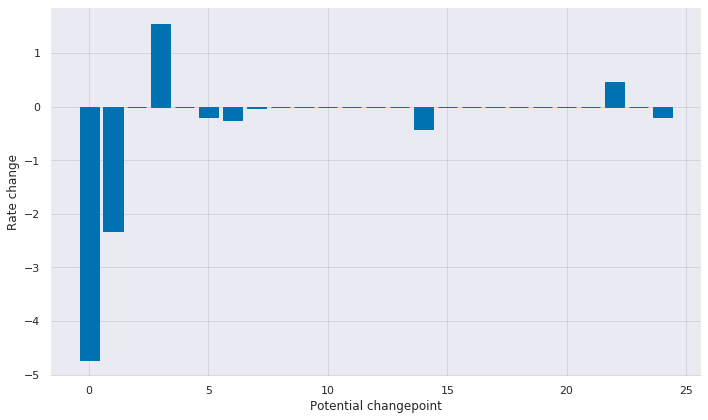

In [75]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

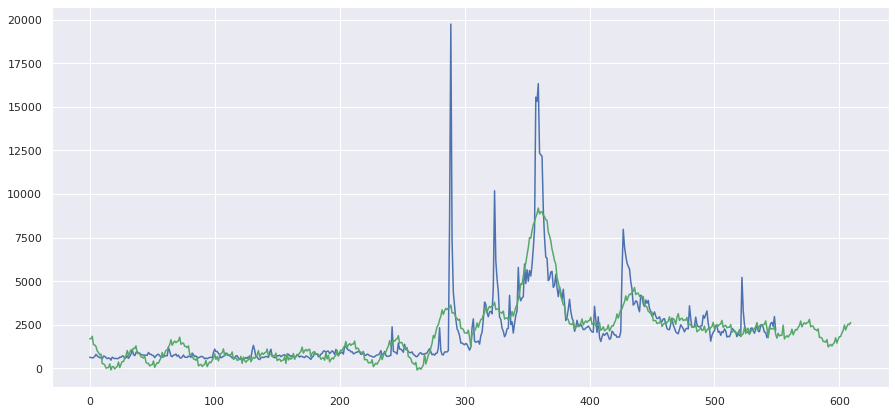

In [76]:
plt.figure(figsize=(15, 7))
plt.plot(df.y)
plt.plot(forecast.yhat, "g");

An interactive figure of the forecast created with Plotly

In [77]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

Prophet - All parameters
Let us look at a summary of some of the most important Prophet parameters for reference.

Trend parameters

Parameter and Description

growth -> linear’ or ‘logistic’ to specify a linear or logistic trend
changepoints -> List of dates at which to include potential changepoints (automatic if not specified)
n_changepoints -> If changepoints is not supplied, you may provide the number of changepoints to be automatically included
changepoint_prior_scale -> Parameter for changing flexibility of automatic changepoint selection
Seasonality & Holiday Parameters

Parameter and Description

yearly_seasonality -> Fit yearly seasonality
weekly_seasonality -> Fit weekly seasonality
daily_seasonality -> Fit daily seasonality
holidays -> Feed dataframe containing holiday name and date
seasonality_prior_scale -> Parameter for changing strength of seasonality model
holidays_prior_scale -> Parameter for changing strength of holiday model
Source: https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [78]:
m.params

{'beta': array([[-2.07657759e-02, -8.92613283e-02, -1.93200448e-02,
          3.81712311e-02,  2.25766438e-02, -1.69339531e-02,
         -1.55653421e-02,  3.11520497e-02,  1.80158520e-02,
         -3.72641583e-02, -1.63979737e-02,  2.43112005e-02,
          9.14502988e-03, -6.98662134e-03, -3.32118755e-03,
          6.20717342e-03,  1.73652301e-02, -2.03056347e-02,
         -3.16760919e-02,  6.55264042e-03,  1.33986943e-03,
          3.60695661e-03,  4.47441511e-03,  2.49347714e-03,
          1.37288437e-03, -4.70381082e-03,  5.54039649e-09,
         -4.99441139e-02,  1.10807930e-08, -4.99441139e-02,
         -6.54524283e-08, -4.99441139e-02,  2.21615859e-08,
         -4.99441139e-02,  6.70156048e-03, -1.28112297e-02,
         -1.73301682e-02,  2.37701234e-02, -3.33675536e-02,
          2.05959481e-02,  1.04299055e-02, -3.09342897e-02,
         -9.77147200e-04,  1.39008779e-02,  1.80676787e-02]]),
 'delta': array([[-4.71985323e+00, -2.32262333e+00, -1.46734785e-06,
          1.54965679

Evaluating the Model
SMAPE function

SMAPE=100%n∑t=1n|Ft−At|(|At|+|Ft|)/2

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)



Calculating the SMAPE for the time series prediction for the visits at a single URL page

In [80]:
smape_single_page = smape(df.y, forecast.yhat)
smape_single_page


38.10621485344787

**Prophet - Cross Validation**

In [0]:
from fbprophet.diagnostics import cross_validation

In [82]:
# horizon: forecast horizon
# initial: size of the initial training period
# period: spacing between cutoff dates
#
# Here we do cross-validation to assess prediction performance on a horizon of 60 days, 
# starting with 130 days of training data in the first cutoff and then making predictions every 60 days
# On this 610 days time series, this corresponds to 8 total forecasts

cv_results = cross_validation(m, initial='360 days', period='30 days', horizon='60 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-07-04 00:00:00 and 2016-11-01 00:00:00


In [83]:
smape_baseline = smape(cv_results.y, cv_results.yhat)
smape_baseline

100.56329986665786

**Prophet - Running for Multiple Time Series**

In [84]:
train_1_all = train_1.drop(['Page','Site','Country','Agent'], axis=1).T
train_1_all.columns = train_1.Page.values
train_1_all.shape

(550, 24737)

In [85]:
train_1_all.head()

2NE1_zh.wikipedia.org_all-access_spider  ...  Marie-Anne_Chazel_fr.wikipedia.org_all-access_all-agents
2015-07-01                                     18.0  ...                                              233.0       
2015-07-02                                     11.0  ...                                              204.0       
2015-07-03                                      5.0  ...                                              198.0       
2015-07-04                                     13.0  ...                                              217.0       
2015-07-05                                     14.0  ...                                              258.0       

[5 rows x 24737 columns]

In [0]:
# Filling up NaN values with 0 visits to avoid breaking the model fit
train_1_all.fillna(0, inplace=True)

# Selecting a few series to run the Prophet model against
num_series = 10
train_1_sample = train_1_all.sample(num_series, axis=1, random_state=42)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

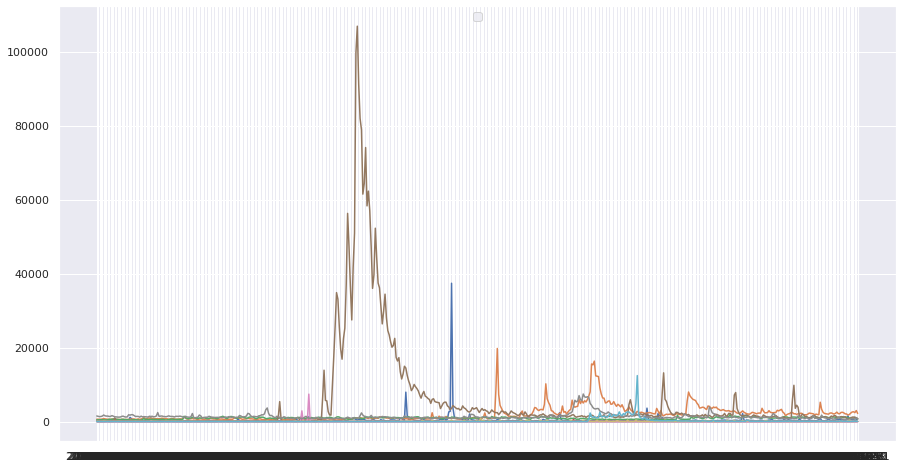

In [87]:
# Plotting the Series from the sample datasets at the same graph
plt.figure(figsize=(15,8))

for v in train_1_sample.columns:
    plt.plot(train_1_sample[v])
    plt.legend(loc='upper center');

In [88]:
%%time

smape_partial = 0

for k, v in enumerate(train_1_sample.columns):
    ds = pd.Series(train_1_sample.index)
    y = pd.Series(train_1_sample.iloc[:,k].values)
    frame = { 'ds': ds, 'y': y }
    df = pd.DataFrame(frame)
    m_partial = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    forecast = m_partial.fit(df).predict(future)
    smape_partial += smape(df.y, forecast.yhat)

smape_average = smape_partial / len(train_1_sample.columns)
smape_average

CPU times: user 52.3 s, sys: 32.3 s, total: 1min 24s
Wall time: 47.2 s


Multivariate Time Series models
I could be using Multivariate Time Series (MTS) instead of the univariate models against all Time Series.
Following this approach, below are some ideas I could try in the future:

Vector Auto Regression (VAR)
Johansen’s test for checking the stationarity of any multivariate time series data
(statsmodels.tsa.vector_ar.vecm import coint_johansen)
Fit the model using VAR model from statsmodel library
(from statsmodels.tsa.vector_ar.var_model import VAR)
Random Forest
Recurrent Neural Networs (RNN)
Sources:

A Multivariate Time Series Guide to Forecasting and Modeling (with Python codes))
Multivariate Time Series Forecasting Using Random Forest)
Interpreting recurrent neural networks on multivariate time series

Multiple Time Series in parallel
Another idea could be the use of Python multiprocessing package to forecast multiple Time Series in parallel.

**Submitting to Kaggle**

In [0]:
# train_1_sampleT.columns[1]+"_"+"2017-01-01"
# train_1_sampleT.columns[1]+"_"+"2017-01-01" in list(key_1.Page.values)